In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from string import punctuation
#import pyspark


import nltk
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import RegexpTokenizer

In [2]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Users/tom/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
# Read Train Data
col_names = ['sentiment', 'title', 'text']
df = pd.read_csv('../data/train.csv', names=col_names)                

# Data Understanding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   sentiment  int64 
 1   title      object
 2   text       object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB


In [5]:
df.head()

,sentiment,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [6]:
# Check for NaNs
df.isna().sum()

sentiment     0
title        77
text          0
dtype: int64

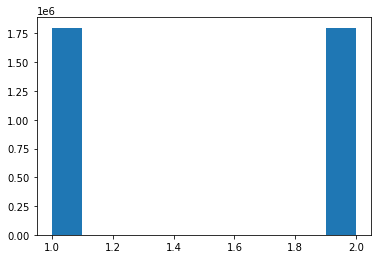

In [7]:
# Visualize sentiment frequency within the dataset
plt.hist(df['sentiment']);

# Data Preprocessing

In [8]:
# Define stopwords and regular expression to be utilized in preprocessing

stop_list = stopwords.words("english") 
regex_pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

## Helper Functions

In [9]:
# POS-Tag Translator

def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk part of speech tags to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [10]:
# Text Cleaner Function

def prepare_text(text, sw=stop_list):
    """
    Tokenize, standardize case, remove punctuation, perform part of speech tagging
    and lemmatize text from string.
    """
    
    # Tokenize words based on the regular expression stored in regex_pattern
    tokenizer = RegexpTokenizer(regex_pattern)
    tokens = tokenizer.tokenize(text)
    
    # Convert tokens to lowercase and remove words in the stop_list variable
    tokens = [token.lower() for token in tokens if token.lower() not in sw]
    
    # Perform part of speech tagging
    tokens_tagged = pos_tag(tokens)
    tokens_tagged = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged]
    
    # Perform lemmatization 
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word[0], word[1]) for word in tokens_tagged]
    
    # Return a string consisting of all tokens
    return ' '.join(tokens)

In [11]:
# Visualization Function to plot the 20 most common words in a frequency distribution object

def visualize_top_10(freq_dist, title):
    
    plt.style.use('fivethirtyeight')
    plt.rcParams.update({'font.size': 13})
        
    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    plt.tight_layout()
    
    # Save png of image to images folder using title as filename
    # plt.savefig(f'./images/{title}', facecolor='white', dpi=500)

In [12]:
# Test function on one row
sample_row = prepare_text(df['text'][0])
print(sample_row)

# Print original text for inspection
df['text'][0]

sound track beautiful paint senery mind well would recomend even people hate vid game music play game chrono cross game ever play best music back away crude keyboarding take fresh step grate guitar soulful orchestra would impress anyone care listen


'This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^'

In [13]:
# Apply helper function to 'text' column and store the output in a new column
# df['text_cleaned'] = df['text'].apply(prepare_text)

# Store list of tokens in new column for visual exploration
# df['toks'] = df['text_cleaned'].str.split()

In [20]:
# Create new dataframe with cleaned text and sentiment, save to csv.
# df.to_csv('../data/train_cleaned.csv', columns=['sentiment', 'text_cleaned', 'toks'])

In [ ]:
# Ten Most common words in the full dataset
sample_freq_dist = FreqDist(df["text_cleaned"].str.split().explode())
visualize_top_10(sample_freq_dist, "Most Common Words in All Reviews")

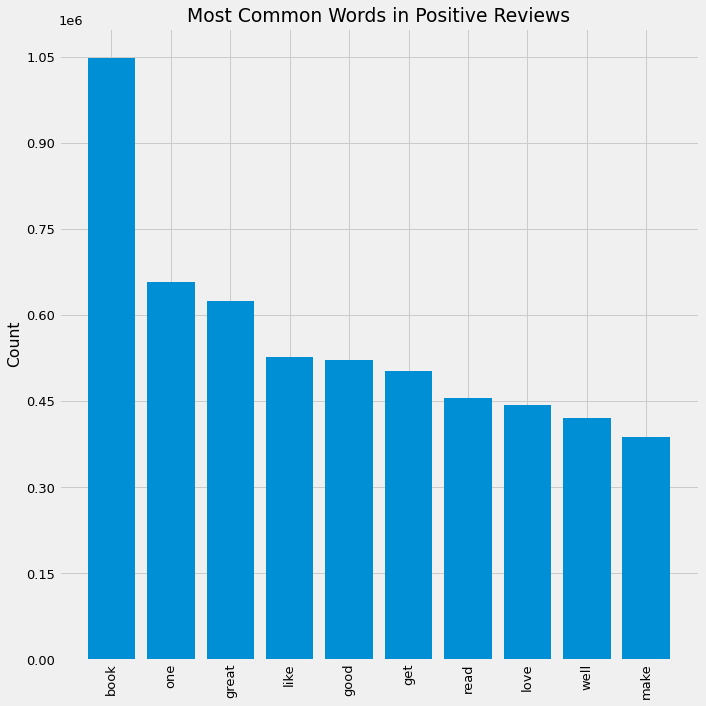

In [28]:
# Ten most common words appearing in negative tweets
pos_freq_dist = FreqDist(df['toks'].explode().loc[df['sentiment'] == 2])
visualize_top_10(pos_freq_dist, 'Most Common Words in Positive Reviews')

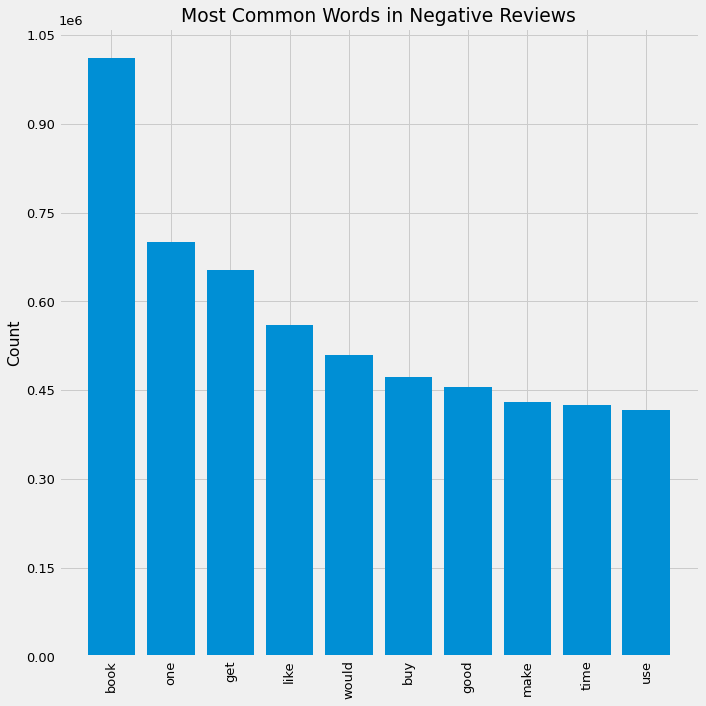

In [32]:
# Ten most common words appearing in negative reviews
neg_freq_dist = FreqDist(df['toks'].explode().loc[df['sentiment'] == 1])
visualize_top_10(neg_freq_dist, 'Most Common Words in Negative Reviews')

## Transform Test Data

In [15]:
# Read in valdiation data
df_test = pd.read_csv('../data/test.csv', names=col_names) 

In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  400000 non-null  int64 
 1   title      399990 non-null  object
 2   text       400000 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB


In [17]:
# Apply cleaning function to the validation set
# df_test['text_cleaned'] = df_test['text'].apply(prepare_text)

# Store list of tokens in new column for visual exploration
# df_test['toks'] = df_test['text_cleaned'].str.split()

In [23]:
# Save validation data to a new CSV file
# df_test.to_csv('../data/train_cleaned.csv', columns=['sentiment', 'text_cleaned', 'toks'])

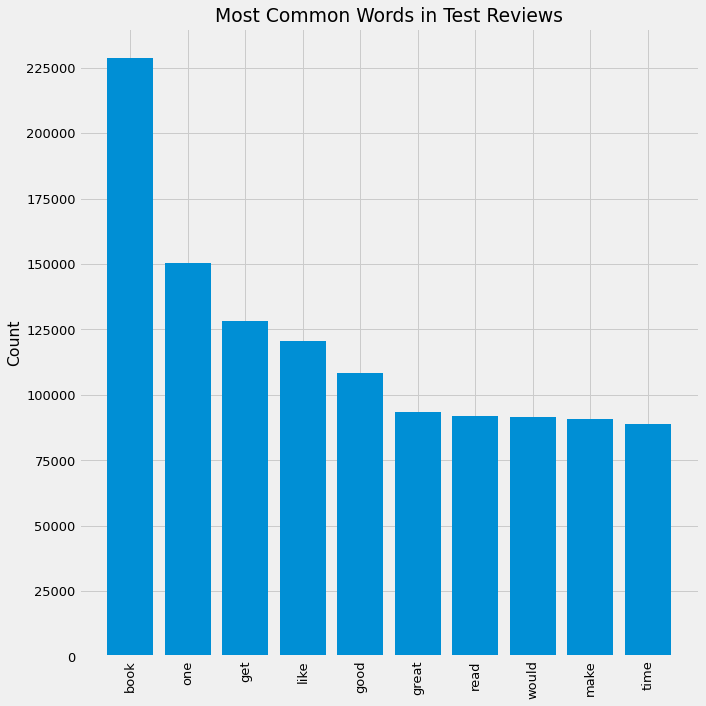

In [26]:
# Ten Most common words in the test dataset
test_freq_dist = FreqDist(df_test["toks"].explode())
visualize_top_10(test_freq_dist, "Most Common Words in Test Reviews")